In [1]:
from NLP_project.evaluation.eval_utils import *
import json
from NLP_project.retrieval import *

d:\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading passages from ./NLP_project/data/chunked_text_all_together_cleaned.json


In [66]:
# 1. Load the corpus passages and corresponding chunk IDs.
passages, chunk_ids = load_passages_and_chunk_ids()

# 2. Build the TF-IDF index.
vectorizer, doc_matrix = build_tfidf_index(passages)

# 3. Load ground truth data (a JSON file with a list of examples).
# Each example is expected to have a "question" and a "list of reference"
# File Paths
DATA_PATH = "./NLP_project/data"
QA_PATH = f"{DATA_PATH}/QA_set"
QA_EMBEDDED_PATH = f"{DATA_PATH}/QA_set_embedded"



CORPUS_FILE = os.path.join(DATA_PATH, "chunked_text_all_together_cleaned.json")

# Ground truth dataset files.
EASY = os.path.join(QA_PATH, "easy_single_labeled.json")
MEDIUM_S = os.path.join(QA_PATH, "medium_single_labeled.json")
MEDIUM_M = os.path.join(QA_PATH, "medium_multi_labeled.json")
HARD_S = os.path.join(QA_PATH, "hard_single_labeled.json")
HARD_M = os.path.join(QA_PATH, "hard_multi_labeled.json")


# -----------------------------
# Load Sub-Queries Lists for Each Dataset
# -----------------------------
subqueries_easy = retrieve_all_subqueries(EASY)
subqueries_medium_s = retrieve_all_subqueries(MEDIUM_S)
subqueries_medium_m = retrieve_all_subqueries(MEDIUM_M)
subqueries_hard_s = retrieve_all_subqueries(HARD_S)
subqueries_hard_m = retrieve_all_subqueries(HARD_M)

# -----------------------------
# Read the Sub-Query FAISS Indexes for Each Dataset
# -----------------------------
index_easy = faiss.read_index(os.path.join(QA_EMBEDDED_PATH, "bge_easy_single_labeled.index"))
index_medium_s = faiss.read_index(os.path.join(QA_EMBEDDED_PATH, "bge_medium_single_labeled.index"))
index_medium_m = faiss.read_index(os.path.join(QA_EMBEDDED_PATH, "bge_medium_multi_labeled.index"))
index_hard_s = faiss.read_index(os.path.join(QA_EMBEDDED_PATH, "bge_hard_single_labeled.index"))
index_hard_m = faiss.read_index(os.path.join(QA_EMBEDDED_PATH, "bge_hard_multi_labeled.index"))

# -----------------------------
# Load the Global Corpus Dense Embedding FAISS Index
# -----------------------------
CORPUS_EMBEDDING = faiss.read_index('./NLP_project/hp_all_bge.index')

# -----------------------------
# Define Dataset Mapping for Dense Retrieval Evaluation
# -----------------------------
datasets = [
    {"name": "easy_single", "data_file": EASY, "subqueries": subqueries_easy, "subquery_index": index_easy, "retrieval": "dense"},
    {"name": "medium_single", "data_file": MEDIUM_S, "subqueries": subqueries_medium_s, "subquery_index": index_medium_s, "retrieval": "dense"},
    {"name": "medium_multi", "data_file": MEDIUM_M, "subqueries": subqueries_medium_m, "subquery_index": index_medium_m, "retrieval": "dense"},
    {"name": "hard_single", "data_file": HARD_S, "subqueries": subqueries_hard_s, "subquery_index": index_hard_s, "retrieval": "dense"},
    {"name": "hard_multi", "data_file": HARD_M, "subqueries": subqueries_hard_m, "subquery_index": index_hard_m, "retrieval": "dense"}
]

Loaded 9251 passages with chunk IDs


In [67]:

results = []
# loop for different data sets
for ds in datasets:
    print(f"\nLoading ground truth data from {ds['data_file']}...")
    with open(ds["data_file"], "r", encoding="utf-8") as f:
        ground_truth_data = json.load(f)
    print(f"Loaded {len(ground_truth_data)} ground truth examples from {ds['name']}")
# for data_set in [EASY, MEDIUM_S, MEDIUM_M, HARD_S, HARD_M]:
#     # Load the data
#     print(f"Loading data from {data_set}...")
#     text_data_pth = data_set
#     with open(text_data_pth, "r", encoding="utf-8") as f:
#         ground_truth_data = json.load(f)
#     # count the iterms in the file
#     print(f"Loaded {len(ground_truth_data)} ground truth examples")

    # 4. Prepare containers for predictions and ground truth references.
    predictions = []  # Each entry is a list of predicted chunk_ids for a query.
    references = []   # Each entry is a list of reference IDs for a query.

    # 5. For each ground truth example, run the retrieval and store predictions.
    for example in ground_truth_data:
        question = example["question"]
        retrieval_results = tfidf_retrieval(question, vectorizer, doc_matrix, passages, chunk_ids, top_k=5)
        
        # Store the predicted chunk IDs (convert to string if necessary).
        pred_ids = [str(result["chunk_id"]) for result in retrieval_results]
        predictions.append(pred_ids)
        
        # Store ground truth reference IDs (assuming each reference has a "ref_id").
        gt_ids = [str(ref["ref_id"]) for ref in example["list of reference"]]
        references.append(gt_ids)

    # 6. Initialize the retrieval evaluation metrics.
    eval_collection = MetricCollection({
        "recall@5": RecallAtK(k=5),
        "precision@5": PrecisionAtK(k=5),
        "mrr": MRR(),
        "ndcg@5": nDCG(k=5)
    })

    # 7. Update the metrics with the entire set of predictions and ground truth references.
    eval_collection.update(predictions, references, metric_type="retrieval")

    # 8. Compute the overall evaluation metrics.
    overall_metrics = eval_collection.compute(metric_type="retrieval")
    print("\nOverall Retrieval Evaluation Metrics:")
    print(json.dumps(overall_metrics, indent=2))
    results.append({'performance': overall_metrics, "data_set": ds["name"], 'retrieval': 'tfidf'})


Loading ground truth data from ./NLP_project/data/QA_set\easy_single_labeled.json...
Loaded 253 ground truth examples from easy_single

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.08389261744966443,
  "precision@5": 0.019762845849802372,
  "mrr": 0.054545454545454536,
  "ndcg@5": 0.05913122106512458
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_single_labeled.json...
Loaded 91 ground truth examples from medium_single

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.136,
  "precision@5": 0.03736263736263736,
  "mrr": 0.11153846153846154,
  "ndcg@5": 0.1106424051223992
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_multi_labeled.json...
Loaded 35 ground truth examples from medium_multi

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.006802721088435374,
  "precision@5": 0.005714285714285714,
  "mrr": 0.02857142857142857,
  "ndcg@5": 0.017518491221870238
}

Loading ground truth data from ./NLP_project/data/QA_set\hard_s

In [68]:
bm25 = build_bm25_index(passages)
# for data_set in [EASY, MEDIUM_S, MEDIUM_M, HARD_S, HARD_M]:
#     # Load the data
#     print(f"Loading data from {data_set}...")
#     text_data_pth = data_set
#     with open(text_data_pth, "r", encoding="utf-8") as f:
#         ground_truth_data = json.load(f)
#     # count the iterms in the file
#     print(f"Loaded {len(ground_truth_data)} ground truth examples")
for ds in datasets:
    print(f"\nLoading ground truth data from {ds['data_file']}...")
    with open(ds["data_file"], "r", encoding="utf-8") as f:
        ground_truth_data = json.load(f)
    print(f"Loaded {len(ground_truth_data)} ground truth examples from {ds['name']}")

    # 4. Prepare containers for predictions and ground truth references.
    predictions = []  # Each entry is a list of predicted chunk_ids for a query.
    references = []   # Each entry is a list of reference IDs for a query.

    # 5. For each ground truth example, run the retrieval and store predictions.
    for example in ground_truth_data:
        question = example["question"]
        retrieval_results = bm25_retrieval_subqueries(question, bm25, passages, chunk_ids, top_k=5)
        
        # Store the predicted chunk IDs (convert to string if necessary).
        pred_ids = [str(result["chunk_id"]) for result in retrieval_results]
        predictions.append(pred_ids)
        
        # Store ground truth reference IDs (assuming each reference has a "ref_id").
        gt_ids = [str(ref["ref_id"]) for ref in example["list of reference"]]
        references.append(gt_ids)

    # 6. Initialize the retrieval evaluation metrics.
    eval_collection = MetricCollection({
        "recall@5": RecallAtK(k=5),
        "precision@5": PrecisionAtK(k=5),
        "mrr": MRR(),
        "ndcg@5": nDCG(k=5)
    })

    # 7. Update the metrics with the entire set of predictions and ground truth references.
    eval_collection.update(predictions, references, metric_type="retrieval")

    # 8. Compute the overall evaluation metrics.
    overall_metrics = eval_collection.compute(metric_type="retrieval")
    print("\nOverall Retrieval Evaluation Metrics:")
    print(json.dumps(overall_metrics, indent=2))
    results.append({'performance': overall_metrics, "data_set": ds["name"], 'retrieval': 'bm25'})


Loading ground truth data from ./NLP_project/data/QA_set\easy_single_labeled.json...
Loaded 253 ground truth examples from easy_single

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.08389261744966443,
  "precision@5": 0.019762845849802372,
  "mrr": 0.05151515151515152,
  "ndcg@5": 0.05909196015880151
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_single_labeled.json...
Loaded 91 ground truth examples from medium_single

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.12,
  "precision@5": 0.03296703296703297,
  "mrr": 0.10732600732600733,
  "ndcg@5": 0.11453206515215979
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_multi_labeled.json...
Loaded 35 ground truth examples from medium_multi

Overall Retrieval Evaluation Metrics:
{
  "recall@5": 0.027210884353741496,
  "precision@5": 0.022857142857142857,
  "mrr": 0.04952380952380952,
  "ndcg@5": 0.03288943101954012
}

Loading ground truth data from ./NLP_project/data/QA_set\hard_sin

In [69]:


# Assume these functions are defined or imported:
# - load_passages_and_chunk_ids()
# - retrieve_all_subqueries(file_path)
# - dense_retrieval_subqueries(queries, all_queries_list, sub_queries_index, faiss_index, passages, chunk_ids, top_k=5)

# -----------------------------
# File Paths and Global Variables
# -----------------------------


 # To store evaluation results for each dataset.

# -----------------------------
# Loop Over Each Dataset for Dense Retrieval Evaluation
# -----------------------------
for ds in datasets:
    print(f"\nLoading ground truth data from {ds['data_file']}...")
    with open(ds["data_file"], "r", encoding="utf-8") as f:
        ground_truth_data = json.load(f)
    print(f"Loaded {len(ground_truth_data)} ground truth examples from {ds['name']}")

    predictions = []  # Each entry: list of predicted chunk IDs for a query.
    references = []   # Each entry: list of ground truth ref_ids for a query.
    
    for example in ground_truth_data:
        question = example["sub_questions"]
        # Run dense retrieval using sub-queries for the given question.
        retrieval_results = dense_retrieval_subqueries(
            question,
            ds["subqueries"],
            ds["subquery_index"],
            CORPUS_EMBEDDING,
            passages,
            chunk_ids,
            top_k=5
        )
        # Convert predicted chunk IDs to strings.
        pred_ids = [str(result["chunk_id"]) for result in retrieval_results]
        predictions.append(pred_ids)
        # Ground truth: extract ref_ids from each reference.
        gt_ids = [str(ref["ref_id"]) for ref in example["list of reference"]]
        references.append(gt_ids)
    
    # Initialize the retrieval evaluation metrics.
    eval_collection = MetricCollection({
        "recall@5": RecallAtK(k=5),
        "precision@5": PrecisionAtK(k=5),
        "mrr": MRR(),
        "ndcg@5": nDCG(k=5)
    })
    
    # Update the metrics and compute the overall evaluation.
    eval_collection.update(predictions, references, metric_type="retrieval")
    overall_metrics = eval_collection.compute(metric_type="retrieval")
    print(f"\nOverall Dense Retrieval Evaluation Metrics for {ds['name']}:")
    print(json.dumps(overall_metrics, indent=2))
    
    # Store the results along with dataset name and retrieval method.
    results.append({
        'performance': overall_metrics,
        'data_set': ds["name"],
        'retrieval': ds["retrieval"]
    })





Loading ground truth data from ./NLP_project/data/QA_set\easy_single_labeled.json...
Loaded 253 ground truth examples from easy_single

Overall Dense Retrieval Evaluation Metrics for easy_single:
{
  "recall@5": 0.15100671140939598,
  "precision@5": 0.03557312252964427,
  "mrr": 0.10671936758893277,
  "ndcg@5": 0.11317977067850814
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_single_labeled.json...
Loaded 91 ground truth examples from medium_single

Overall Dense Retrieval Evaluation Metrics for medium_single:
{
  "recall@5": 0.152,
  "precision@5": 0.01391941391941392,
  "mrr": 0.13235653235653236,
  "ndcg@5": 0.12090768227829109
}

Loading ground truth data from ./NLP_project/data/QA_set\medium_multi_labeled.json...
Loaded 35 ground truth examples from medium_multi

Overall Dense Retrieval Evaluation Metrics for medium_multi:
{
  "recall@5": 0.034013605442176874,
  "precision@5": 0.009523809523809525,
  "mrr": 0.08878787878787879,
  "ndcg@5": 0.0492483564001426


In [62]:
print(json.dumps(results)) 
# Save the results to a JSON file.
with open("retrieval_results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Results saved to retrieval_results.json")


[{"perfermance": {"recall@5": 0.08389261744966443, "precision@5": 0.019762845849802372, "mrr": 0.054545454545454536, "ndcg@5": 0.05913122106512458}, "data_set": "easy_single", "retrieval": "tfidf"}, {"perfermance": {"recall@5": 0.136, "precision@5": 0.03736263736263736, "mrr": 0.11153846153846154, "ndcg@5": 0.1106424051223992}, "data_set": "medium_single", "retrieval": "tfidf"}, {"perfermance": {"recall@5": 0.006802721088435374, "precision@5": 0.005714285714285714, "mrr": 0.02857142857142857, "ndcg@5": 0.017518491221870238}, "data_set": "medium_multi", "retrieval": "tfidf"}, {"perfermance": {"recall@5": 0.05555555555555555, "precision@5": 0.01818181818181818, "mrr": 0.0303030303030303, "ndcg@5": 0.02787032694388447}, "data_set": "hard_single", "retrieval": "tfidf"}, {"perfermance": {"recall@5": 0.08333333333333333, "precision@5": 0.03333333333333333, "mrr": 0.05555555555555555, "ndcg@5": 0.05109559939712153}, "data_set": "hard_multi", "retrieval": "tfidf"}, {"perfermance": {"recall@5":

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_25284\2706987604.py:38: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


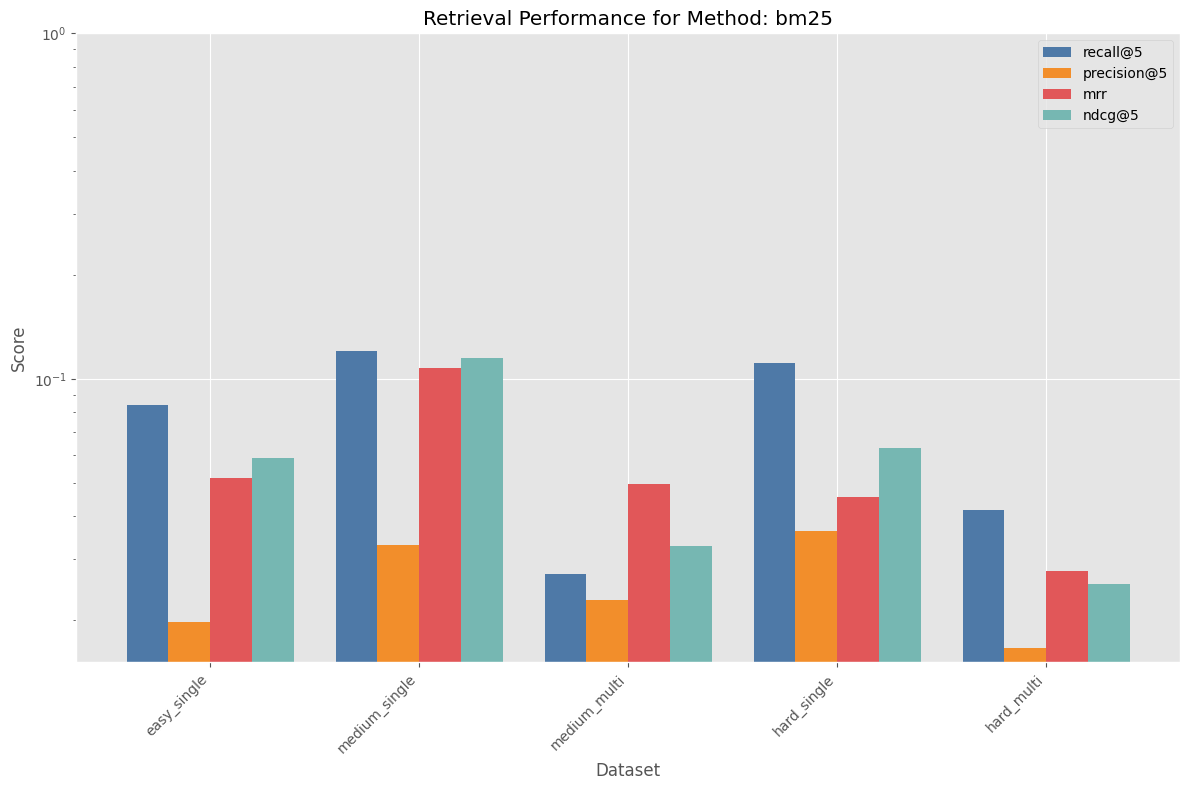

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_25284\2706987604.py:38: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


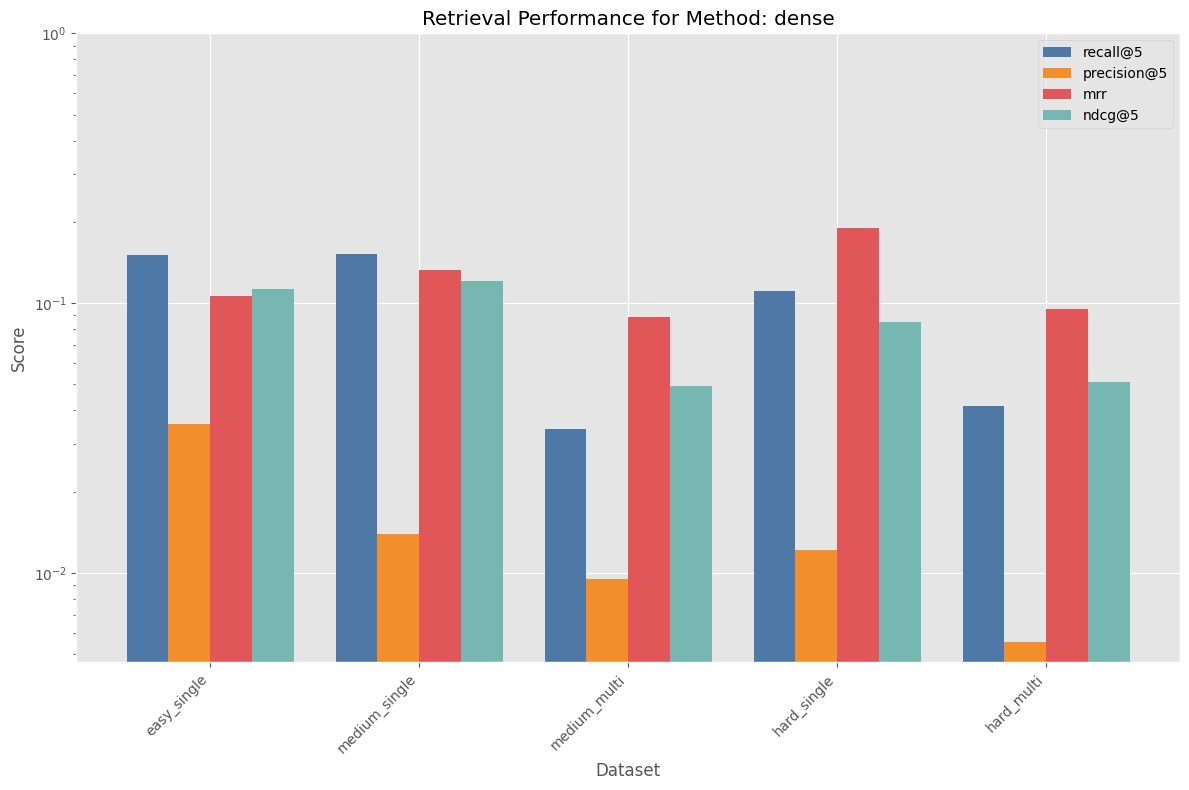

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_25284\2706987604.py:38: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


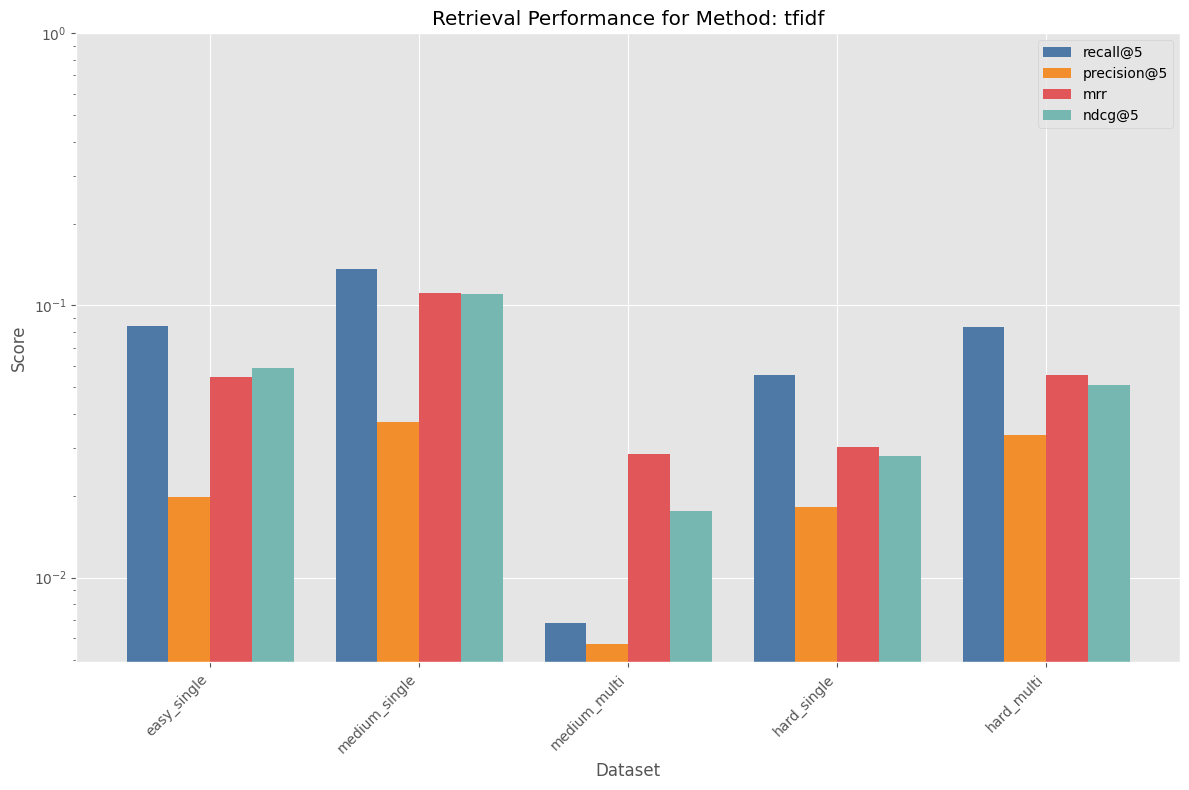

In [76]:
# Extract unique retrieval methods from the results.
retrieval_methods = sorted(list(set(r['retrieval'] for r in results)))

# Define an updated color palette for the metrics.
metric_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Loop over each retrieval method and plot its performance.
for method in retrieval_methods:
    # Filter the results for the current retrieval method.
    method_results = [r for r in results if r['retrieval'] == method]
    
    # Extract dataset names from the filtered results.
    data_set_names = [r['data_set'] for r in method_results]
    
    # Extract metric keys (assuming all items share the same keys).
    metrics = list(method_results[0]['performance'].keys())
    
    n_datasets = len(data_set_names)
    n_metrics = len(metrics)
    indices = np.arange(n_datasets)
    bar_width = 0.2
    
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))
    
    # Plot each metric as separate bars within each dataset group.
    for i, metric in enumerate(metrics):
        positions = indices + i * bar_width
        metric_values = [r['performance'][metric] for r in method_results]
        plt.bar(positions, metric_values, width=bar_width, color=metric_colors[i], label=metric)
    
    # Set x-ticks in the center of each group.
    plt.xticks(indices + bar_width * (n_metrics - 1) / 2, data_set_names, rotation=45, ha='right')
    plt.title(f"Retrieval Performance for Method: {method}")
    plt.xlabel("Dataset")
    plt.ylabel("Score")
    plt.yscale('log')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

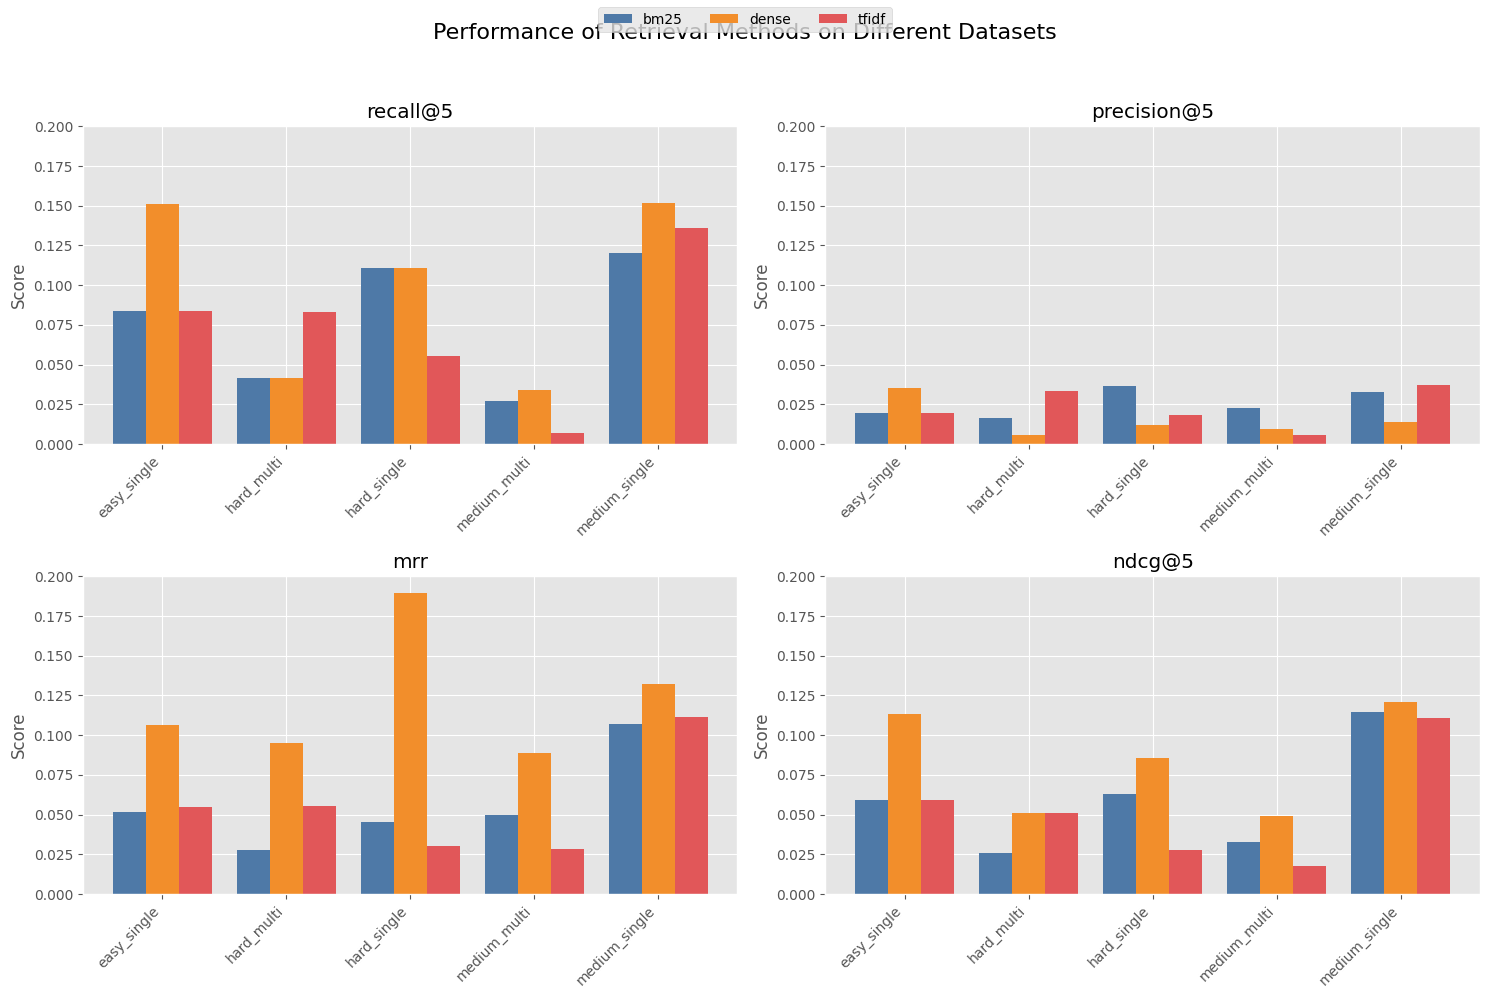

In [79]:
perf_key = 'performance'

# Get unique dataset names and retrieval methods.
dataset_names = sorted(list(set(r["data_set"] for r in results)))
retrieval_methods = sorted(list(set(r["retrieval"] for r in results)))

# Get metric names from one result.
metrics = list(results[0][perf_key].keys())

# Create a dictionary mapping (dataset, method) -> performance dict.
performance_data = {}
for r in results:
    ds = r["data_set"]
    rm = r["retrieval"]
    performance_data[(ds, rm)] = r[perf_key]

# Colors for retrieval methods (one color per method).
retrieval_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Create one plot per metric.
n_metrics = len(metrics)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for m_idx, metric in enumerate(metrics):
    ax = axs[m_idx]
    x = np.arange(len(dataset_names))  # one group per dataset
    bar_width = 0.8 / len(retrieval_methods)  # total width is 0.8

    for i, rm in enumerate(retrieval_methods):
        # For each dataset, get the performance for this retrieval method.
        values = []
        for ds in dataset_names:
            # If there's no entry for this (ds, rm), use 0 (or np.nan).
            value = performance_data.get((ds, rm), {}).get(metric, 0)
            values.append(value)
        # Shift x positions for each retrieval method.
        positions = x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(positions, values, width=bar_width, color=retrieval_colors[i % len(retrieval_colors)], label=rm if m_idx == 0 else "")
    
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax.set_title(metric)
    #ax.set_ylim(0, 1)
    ax.set_ylim(0, 0.2)
    ax.set_ylabel("Score")

# Add a common legend.
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(retrieval_methods))
fig.suptitle("Performance of Retrieval Methods on Different Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

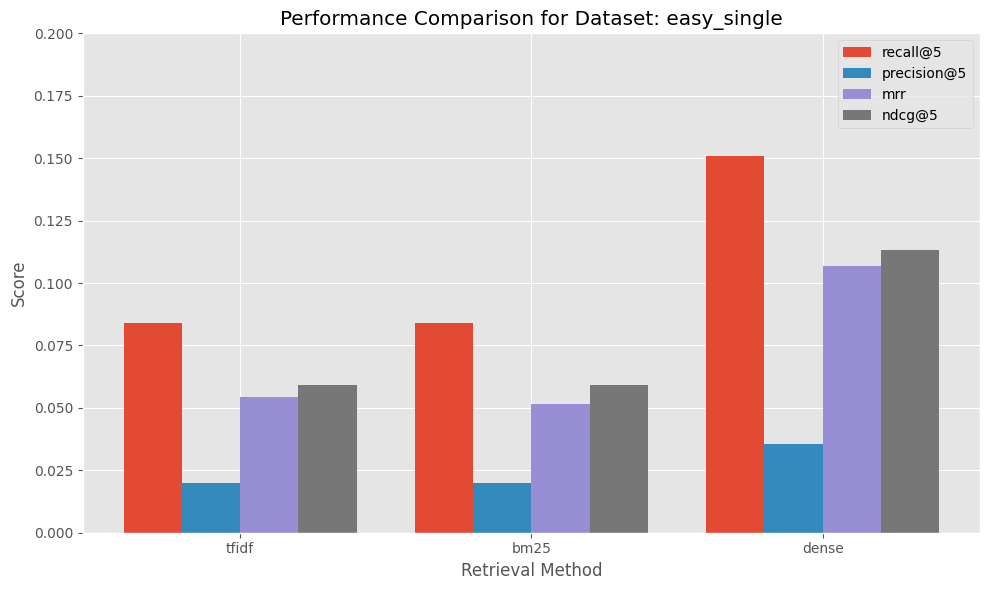

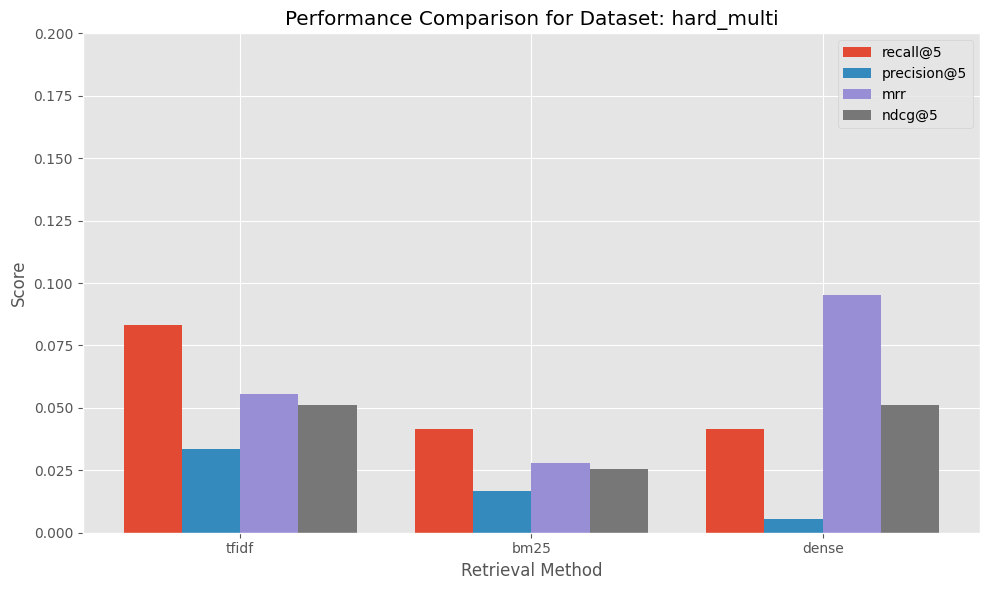

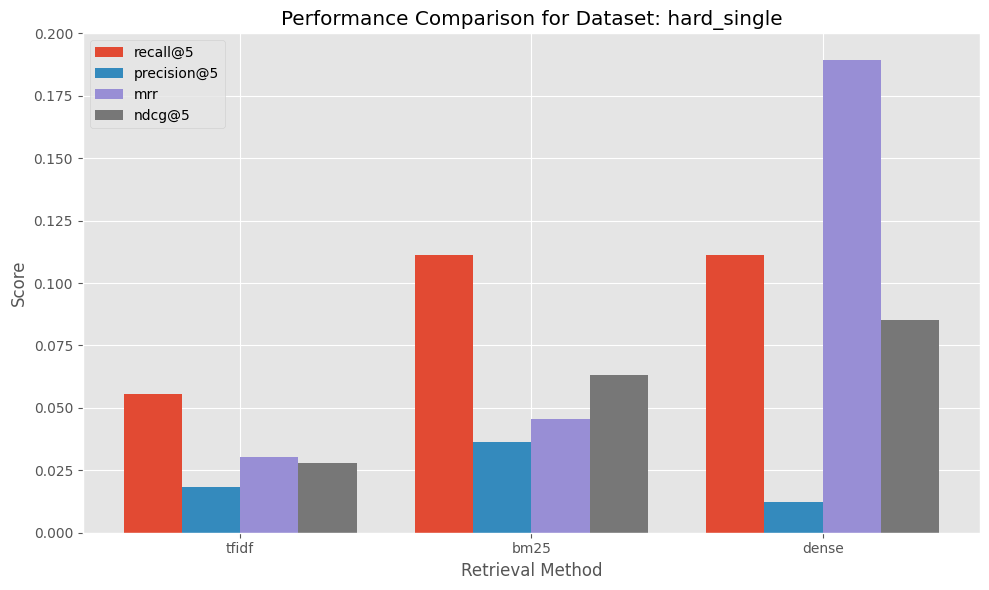

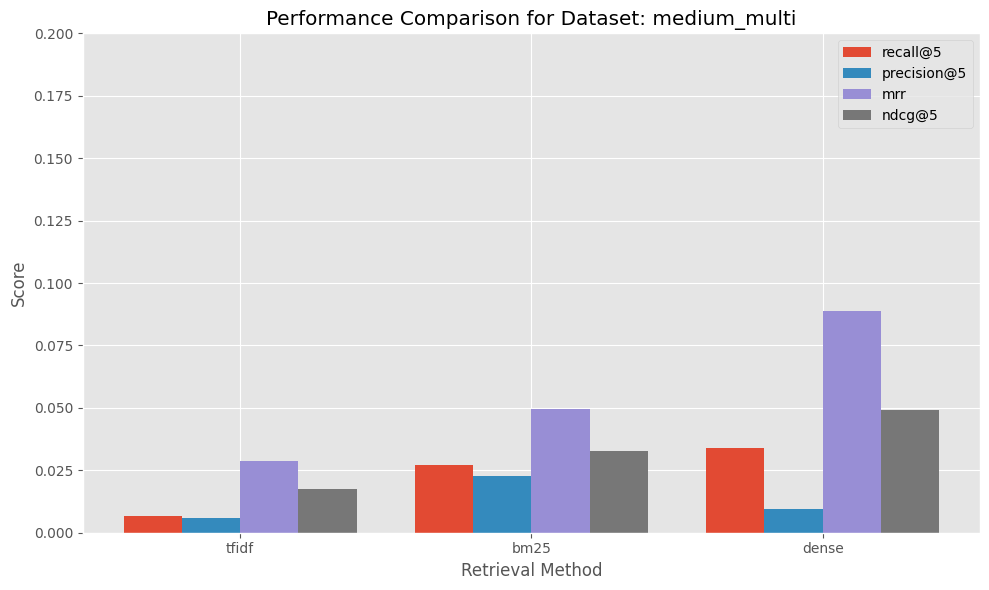

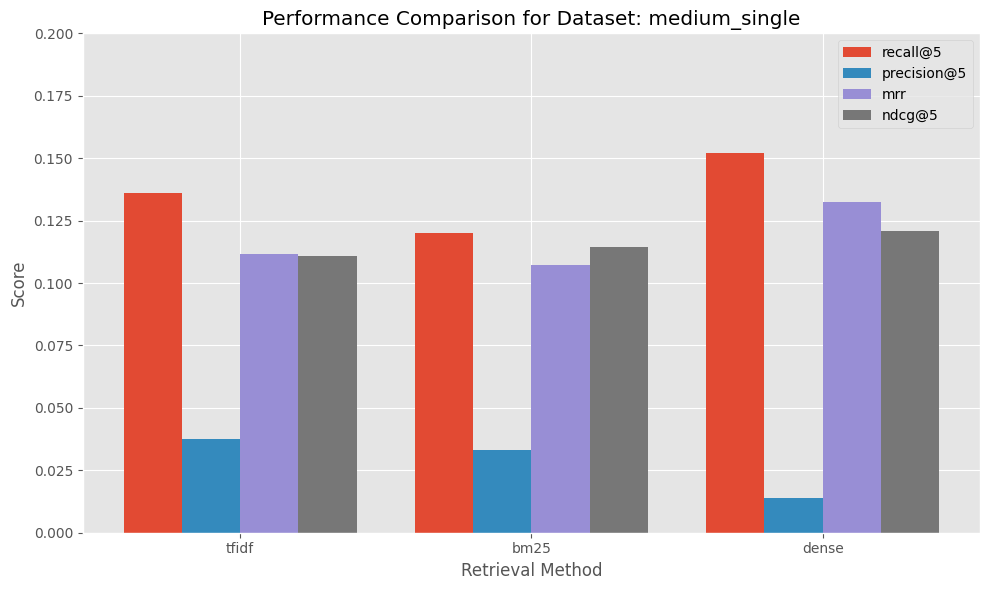

In [81]:
performance_key = "perfermance" if "perfermance" in results[0] else "performance"

# Get unique dataset names.
dataset_names = sorted(list(set(r["data_set"] for r in results)))

# Loop over each dataset and plot a grouped bar chart comparing retrieval methods.
for ds in dataset_names:
    # Filter results for this dataset.
    ds_results = [r for r in results if r["data_set"] == ds]
    # Get the list of retrieval methods (x-axis labels).
    retrieval_methods = [r["retrieval"] for r in ds_results]
    
    # Extract the metric keys (e.g., recall@5, precision@5, etc.).
    metrics = list(ds_results[0][performance_key].keys())
    
    n_methods = len(retrieval_methods)
    n_metrics = len(metrics)
    indices = np.arange(n_methods)
    # The width of each bar within a group.
    bar_width = 0.8 / n_metrics  # total group width is 0.8
    
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    
    # Plot bars for each metric.
    for i, metric in enumerate(metrics):
        # Get the metric value for each retrieval method.
        values = [r[performance_key][metric] for r in ds_results]
        # Offset the bar positions within each group.
        positions = indices - 0.4 + i * bar_width + bar_width / 2
        plt.bar(positions, values, width=bar_width, label=metric)
    
    # Set the x-ticks to be at the center of each group.
    plt.xticks(indices, retrieval_methods)
    plt.title(f"Performance Comparison for Dataset: {ds}")
    plt.xlabel("Retrieval Method")
    plt.ylabel("Score")
    #plt.ylim(0, 1)
    plt.ylim(0, 0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()